In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset


In [54]:
dataset = load_dataset("mediabiasgroup/mbib-base", "gender-bias")
df = dataset['train'].to_pandas()

Found cached dataset mbib-base (/Users/antoniocastaldo/.cache/huggingface/datasets/mediabiasgroup___mbib-base/gender-bias/1.0.0/cf6f80c612f1363f2162f92f58e1113915a6b01aa07680513a18b7d94570e875)
100%|██████████| 1/1 [00:00<00:00, 554.29it/s]


In [56]:
df['n_words'] = df.text.apply(lambda x: len(x.split()))

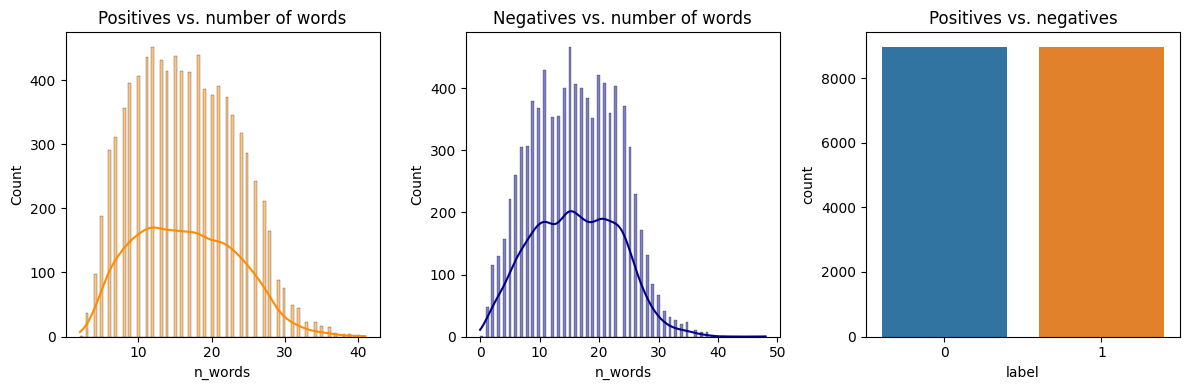

In [142]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4));  # Create subplots with 2 rows and 1 column

# Set titles for individual plots
axs[0].set_title('Positives vs. number of words');
axs[1].set_title('Negatives vs. number of words');
axs[2].set_title('Positives vs. negatives');

# Plot histograms for positives and negatives
sns.histplot(df[df.label == 1].n_words, bins=100, kde=True, ax=axs[0], color='darkorange');
sns.histplot(df[df.label == 0].n_words, bins=100, kde=True, ax=axs[1], color='darkblue');
sns.countplot(x='label', data=df, ax=axs[2]);

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


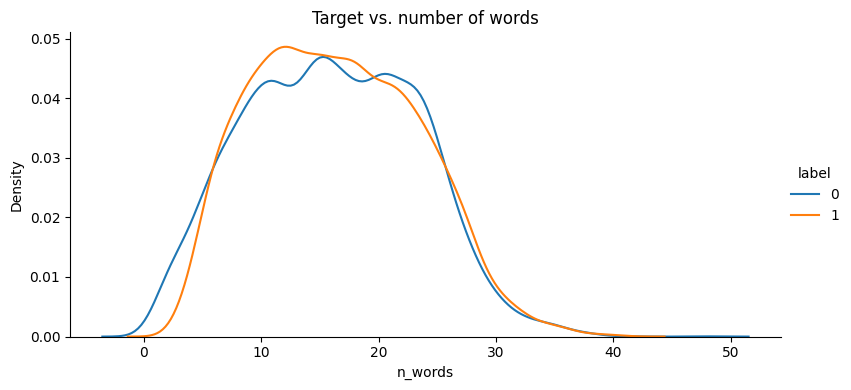

In [107]:
grid = sns.FacetGrid(df, hue="label", height=4, aspect=2)
# Set titles for individual plots
grid.axes[0, 0].set_title('Target vs. number of words');
grid.map(sns.kdeplot, "n_words")
grid.add_legend();

In [126]:
print('The dataset contains {} rows and {} columns'.format(df.shape[0], df.shape[1]))
print('The dataset contains {} positive and {} negative rows'.format(df.label.sum(), (1 - df.label).sum()))
print('The average number of words in the text is {:.0f}'.format(df.n_words.mean()))
print('The maximum number of words in the text is {:.0f}'.format(df.n_words.max()))
print('The minimum number of words in the text is {:.0f}'.format(df.n_words.min()))

The dataset contains 17940 rows and 4 columns
The dataset contains 8970 positive and 8970 negative rows
The average number of words in the text is 16
The maximum number of words in the text is 48
The minimum number of words in the text is 0


(-0.5, 799.5, 399.5, -0.5)

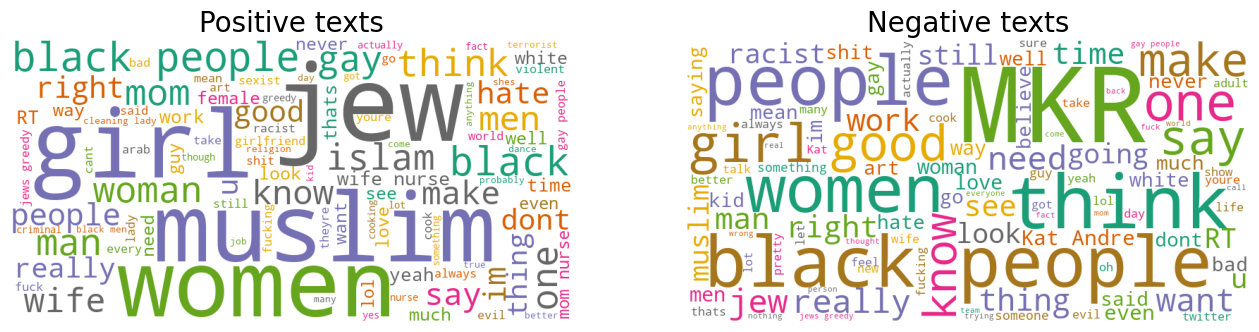

In [187]:
from wordcloud import WordCloud, STOPWORDS
from textwrap import wrap

# Create a wordcloud for positive and negative texts
pos_text = ' '.join(df[df.label == 1].text)
neg_text = ' '.join(df[df.label == 0].text)
wc = WordCloud(stopwords=STOPWORDS, background_color='white', colormap='Dark2', max_font_size=150, random_state=42, width=800, height=400, max_words=100).generate(pos_text)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wc.generate(pos_text))
plt.title('Positive texts', fontsize=20)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wc.generate(neg_text))
plt.title('Negative texts', fontsize=20)
plt.axis('off')

In [156]:
print('Number of rows with the word "mkr": {}'.format(df.text.str.contains('mkr').sum()))
print('Number of rows with the word "mkr" and label 1: {}'.format(df[df.label == 1].text.str.contains('mkr').sum()))
print('Number of rows with the word "mkr" and label 0: {}'.format(df[df.label == 0].text.str.contains('mkr').sum()))
print('\n')
print('Number of words with the word "jew"')
print('Number of rows with the word "jew" and label 0: {}'.format(df[df.label == 0].text.str.contains('jew').sum()))
print('Number of rows with the word "jew" and label 1: {}'.format(df[df.label == 1].text.str.contains('jew').sum()))

Number of rows with the word "mkr": 530
Number of rows with the word "mkr" and label 1: 7
Number of rows with the word "mkr" and label 0: 523


Number of words with the word "jew"
Number of rows with the word "jew" and label 0: 511
Number of rows with the word "jew" and label 1: 916


In [157]:
print('Examples with the word "mkr"')
for example in df[df.text.str.contains('mkr')].sample(3).text.tolist():
    print('- ' + '\n'.join(wrap(example, 100)))

Examples with the word "mkr"
-  mkr how many times does karma have to slap you in the face till you realise you can t cook Kat and
Andre
- I really hope Kat and Andre fail in the most spectacularly and humiliating manner possible
Thoroughly horrible people mkr
- I m gonna gouge my eyes out if this announcer doesn t get off mkr catandandre


In [176]:
# import stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df.text = df.text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
text = ' '.join(df.text)

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer = TfidfVectorizer(
    ngram_range=(2, 4),
    min_df=10,
    max_df=1000,
    max_features=1000,
    use_idf=True)
X = count_vectorizer.fit_transform(df.text)
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [185]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=4)
lda_model.fit(X)

document_topic_mixture = lda_model.transform(X)

In [186]:
def print_topics(lda_model, vectorizer, top_words):
    # 1. TOPIC MIXTURE OF WORDS FOR EACH TOPIC
    topic_mixture = pd.DataFrame(
        lda_model.components_,
        columns = vectorizer.get_feature_names_out()
    )
    
    # 2. FINDING THE TOP WORDS FOR EACH TOPIC

    ## Number of topics
    n_components = topic_mixture.shape[0]

    ## Top words for each topic
    for topic in range(n_components):
        print("-"*10)
        print(f"For topic {topic}, here are the the top {top_words} words with weights:")

        topic_df = topic_mixture.iloc[topic]\
            .sort_values(ascending = False).head(top_words)
        
        print(round(topic_df,3))
        
print_topics(lda_model, count_vectorizer, 5)

----------
For topic 0, here are the the top 5 words with weights:
wife nurse       167.929
black men         88.892
jewish people     76.360
call sexist       55.665
black people      54.913
Name: 0, dtype: float64
----------
For topic 1, here are the the top 5 words with weights:
black people     208.585
jews greedy      147.300
gay people       125.631
mom nurse        123.890
jews inferior     49.409
Name: 1, dtype: float64
----------
For topic 2, here are the the top 5 words with weights:
jews evil            95.931
black people         62.225
like man             57.245
people lazy          43.283
black people lazy    41.912
Name: 2, dtype: float64
----------
For topic 3, here are the the top 5 words with weights:
kat andre             133.380
cleaning lady          84.096
black women            80.952
girlfriend nurse       68.839
muslims terrorists     62.006
Name: 3, dtype: float64
